<a href="https://colab.research.google.com/github/B11GDEN/cvr_homework/blob/main/detection_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import os

import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
!unzip PennFudanPed.zip

--2020-12-20 16:56:13--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  32.9MB/s    in 1.6s    

2020-12-20 16:56:15 (32.9 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2020-12-20 16:56:15--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-12-20 16:56:15--
Total wall clock time: 1.9s
Downloaded: 1 files, 51M in 1.6s (32.9 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [ ]:
def bb_from_mask(mask):
    obj_ids = np.unique(mask)
    obj_ids = obj_ids[1:]
    masks = mask == obj_ids[:, None, None]
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin, xmax = np.min(pos[1]), np.max(pos[1])
        ymin, ymax = np.min(pos[0]), np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes, masks


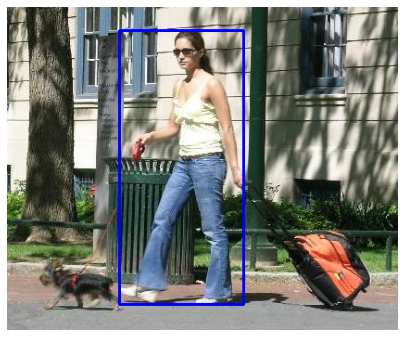

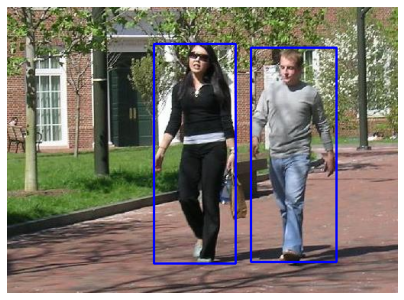

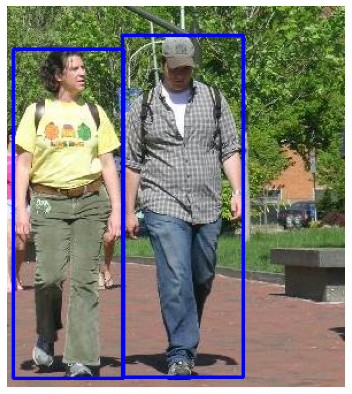

In [ ]:
img_root, msk_root = 'PennFudanPed/PNGImages/', 'PennFudanPed/PedMasks/'
img_fns, msk_fns = sorted(os.listdir(img_root)), sorted(os.listdir(msk_root))
for img_fn, msk_fn in zip(img_fns[-3:], msk_fns[-3:]):
    cur_img = np.array(Image.open(os.path.join(img_root, img_fn)).convert('RGB'))
    cur_msk = np.array(Image.open(os.path.join(msk_root, msk_fn)))
    bboxes, _ = bb_from_mask(cur_msk)

    for bb in bboxes:
        x1,y1,x2,y2 = bb
        cv2.rectangle(cur_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    plt.figure(figsize=(7, 7))
    plt.imshow(cur_img)
    plt.axis('off')
    plt.show()

In [ ]:
class PennFudanDataset(Dataset):

    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))


    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        boxes, masks = bb_from_mask(mask)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = len(masks)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')

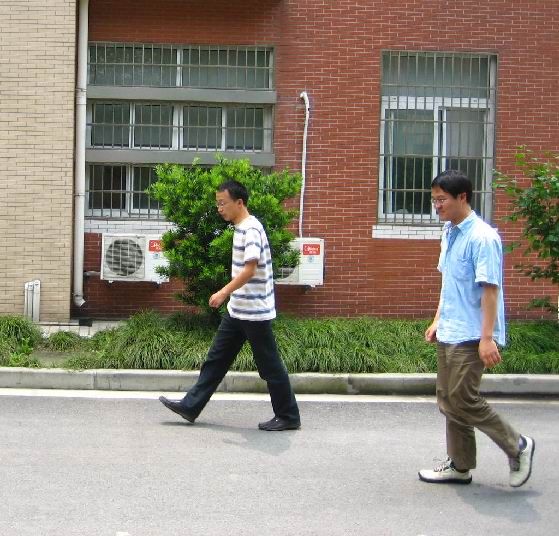

In [ ]:
dataset[0][0]

In [ ]:
print(dataset[0][1].keys())
print(dataset[0][1]['boxes'])

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]])


# Mask R-CNN

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 12143 (delta 13), reused 6 (delta 1), pack-reused 12107
Receiving objects: 100% (12143/12143), 13.45 MiB | 21.89 MiB/s, done.
Resolving deltas: 100% (8468/8468), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1,
)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
# let's train it for 10 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/15]  eta: 0:00:56  lr: 0.000362  loss: 4.3448 (4.3448)  loss_classifier: 0.7412 (0.7412)  loss_box_reg: 0.3965 (0.3965)  loss_mask: 3.1775 (3.1775)  loss_objectness: 0.0246 (0.0246)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 3.7635  data: 0.8473  max mem: 9558
Epoch: [0]  [10/15]  eta: 0:00:14  lr: 0.003930  loss: 1.5749 (1.8310)  loss_classifier: 0.2340 (0.3675)  loss_box_reg: 0.2677 (0.2507)  loss_mask: 0.8504 (1.1820)  loss_objectness: 0.0246 (0.0235)  loss_rpn_box_reg: 0.0074 (0.0073)  time: 2.8231  data: 0.1054  max mem: 10914
Epoch: [0]  [14/15]  eta: 0:00:02  lr: 0.005000  loss: 0.9566 (1.5535)  loss_classifier: 0.2187 (0.3063)  loss_box_reg: 0.2542 (0.2416)  loss_mask: 0.5157 (0.9744)  loss_objectness: 0.0246 (0.0227)  loss_rpn_box_reg: 0.0074 (0.0086)  time: 2.8108  data: 0.0839  max mem: 10914
Epoch: [0] Total time: 0:00:42 (2.8165 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:19  model_time: 0.1940 (0.1940)  evaluator_time: 0.0112 (0.0112)

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[ 71.5785,  37.1991, 189.6479, 326.6247],
          [275.8282,  20.3758, 291.4152,  75.5252],
          [ 79.3318,  52.5887, 182.9020, 212.6898],
          [ 31.8671, 143.3860, 213.1275, 313.2108],
          [ 33.8090,  71.2398, 220.1537, 238.4731]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  .

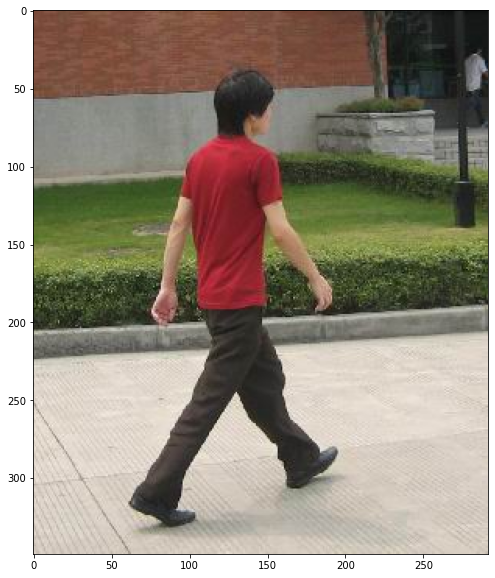

In [ ]:
new_img = img.mul(255).permute(1, 2, 0).byte().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(new_img)
plt.show()

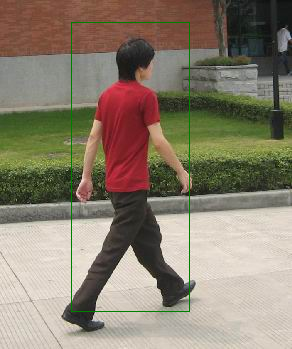

In [ ]:
from PIL import Image, ImageFont, ImageDraw

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
shp = np.array(image).shape
for box in prediction[0]['boxes']:
    box = box.cpu().numpy()
    box[1], box[3] = shp[0] - box[1], shp[0] - box[3]
    ImageDraw.Draw(image).rectangle(box, outline = 'green')
    break

image

# Упражнения

1. Напишите функцию подсчета IoU
2. Реализуйте алгоритм подавления немаксимумов
3. Определить функцию подсчета AUC-PR (площадь под PR кривой)

In [ ]:
def IoU(a, b):
    """
    a,b: np.array, a = (x,y,w,h) or a = (x,y,w,h,p), where:
        x,y - coodinates of top left corner of bounding box
        w,h - width and height of bounding box
        p - detection probability
    ---
    output: IoU metrics
    """
    ax, ay, aw, ah     = a.shape if len(a.shape == 4)
    ax, ay, aw, ah, ap = a.shape if len(a.shape == 5)
    bx, by, bw, bh     = b.shape if len(b.shape == 4)
    bx, by, bw, bh, bp = b.shape if len(b.shape == 4)

    intersection = 0

    if ax >= bx + bw or bx >= ax + aw: intersection = 0
    else if ay >= by + bh or by >= ay + ah: intersection = 0
    else: intersection = min(ax + aw - bx, bx + bw - ax) * min(ay + ah - by, by + bh - ay)

    union = aw*ah + bw*bh - intersection

    return intersection / union


def nms(bboxes, iou_thresh):
    """
    bboxes - bounding boxes for one image, array of shape (N,5)
    iou_thresh - threshold for contolling bbox removal
    ---
    output: array of shape (M,5) of suppessed bounding boxes
    """
    B = list(bboxes)
    D = []
    def sortbyp(x): return x[4]
    B.sort(key = sortbyp, reverse = True)

    while len(B) > 0:
        elem_m = B.pop(0)

        for i, x in enumerate(B):
            if IoU(x, elem_m) > iou_thresh
                B.pop(i)
        
        D.append(elem_m)

    return D

def pr_auc(pr):
    """
    pr - list of tuples (recall, precision, score), sorted by score descend
    ---
    output: Area under precision-recall curve
    """
    return 0

In [21]:
a = np.array([[1, 1, 2], [2, 2, 1], [3, 3, 0]])

In [14]:
def sortbyp(x): return x[2]

In [24]:
b = list(a)
b.sort(key = sortbyp, reverse = True)

In [25]:
print(b)

[array([1, 1, 2]), array([2, 2, 1]), array([3, 3, 0])]


In [28]:
b

[array([2, 2, 1]), array([3, 3, 0])]